In [1]:
import os
import joblib
import lightgbm
import utils_model
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

### Loading dataset

In [2]:
data_path = os.path.join('..', 'data', 'AS24_prepro_data_detail_views.csv')
data_detail_views = pd.read_csv(data_path)
data_detail_views = data_detail_views.set_index('article_id')
data_detail_views.tail()

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,cal_ctr
article_id,,,,,,,,,,,,
348704581,Basic,Lexus,15740,8,2014,12.07.18,19.10.18,6895.0,230.0,100,0.03335750543872371,0.03336
359231940,Basic,Hyundai,2950,6,2006,28.09.18,23.10.18,1175.0,16.0,26,0.012936170212765956,0.01362
362425932,Basic,Volkswagen,7850,8,2014,04.11.18,21.11.18,448.0,21.0,17,0.046875,0.04688
357164227,Basic,Toyota,13945,5,2011,04.09.18,02.10.18,1617.0,29.0,29,0.017934446505875078,0.01793
353639932,Basic,Volkswagen,38800,7,2018,08.08.18,09.08.18,55.0,2.0,2,0.03454545454545454,0.03636


### Encoding of features
There is no requirement of scaling the numerical features as the ensemble learner (LightGBM). This is because at each tree level, the score of a possible split will be equal irrespective of the feature being scaled or not.

In [3]:
ord_enc = OrdinalEncoder()
data_detail_views[["make_name", "product_tier"]] = \
        ord_enc.fit_transform(data_detail_views[["make_name", "product_tier"]])

### Additional - Calendar Features
The creation_date of the advertisement can at times be captured under certain period or season of the calendar and lead to increased detail_views. This captured information can be modelled to predict the target variable under study.

* created_month_of_year - month from the date (1-12)
* created_week_of_year - week in the year (1-52)
* created_day_of_week - day no. of the week (1-7)

In [4]:
data_detail_views['created_date'] = data_detail_views['created_date'].apply(pd.to_datetime)

data_detail_views['created_month_of_year'] = \
data_detail_views['created_date'].dt.month

data_detail_views['created_week_of_year'] = \
data_detail_views['created_date'].dt.date.apply(lambda x: x.isocalendar()[1])

data_detail_views['created_day_of_week'] = \
data_detail_views['created_date'].dt.date.apply(lambda x: x.isocalendar()[2])

#Convert back datetime to numeric as lightgbm does not support datetime format
data_detail_views['created_date'] = pd.to_numeric(data_detail_views['created_date'])

In [5]:
data_detail_views.tail()

,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,cal_ctr,created_month_of_year,created_week_of_year,created_day_of_week
article_id,,,,,,,,,,,,,,,
348704581,0.0,50.0,15740,8,2014,1544140800000000000,19.10.18,6895.0,230.0,100,0.03335750543872371,0.03336,12,49,5
359231940,0.0,38.0,2950,6,2006,1538092800000000000,23.10.18,1175.0,16.0,26,0.012936170212765956,0.01362,9,39,5
362425932,0.0,88.0,7850,8,2014,1523404800000000000,21.11.18,448.0,21.0,17,0.046875,0.04688,4,15,3
357164227,0.0,85.0,13945,5,2011,1523232000000000000,02.10.18,1617.0,29.0,29,0.017934446505875078,0.01793,4,15,1
353639932,0.0,88.0,38800,7,2018,1533686400000000000,09.08.18,55.0,2.0,2,0.03454545454545454,0.03636,8,32,3


### Feature and Target selection

In [6]:
insignificant_cols = ['first_zip_digit', 'deleted_date', 'detail_views', 'ctr', 'cal_ctr']
feature_cols = [cols for cols in data_detail_views.columns if cols not in insignificant_cols]
target_col = ['detail_views']

In [7]:
feature_data = data_detail_views[feature_cols].copy()
target_data = data_detail_views[target_col].copy()

### Train test split

In [10]:
X_train, X_test, y_train, y_test = utils_model.split_train_test(feature_data, target_data)

### Implementation - Grid Search for LightGBM

In [12]:
param_grid = {
    'objective':["regression"],
    'n_estimators': list(range(200, 1000, 200)),
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(10, 50, 10)),
    'learning_rate': [0.01, 0.1],
    'min_child_samples': [20, 50],
    'colsample_bytree': [0.6, 0.8],
    "max_depth": [5, 10],
    "metric":["mape"]
}

In [13]:
# 86 mins run time
lgbm_regressor = lightgbm.LGBMRegressor()
lgbm_cv_reg = GridSearchCV(lgbm_regressor, param_grid, cv=5, verbose=2) 
lgbm_cv_reg.fit(X_train.values, y_train.detail_views.values) 
lgbm_cv_reg.best_params_                                         

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[CV] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.01, max_depth=5, metric=mape, min_child_samples=20, n_estimators=200, num_leaves=10, objective=regression; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.01, max_depth=5, metric=mape, min_child_samples=20, n_estimators=200, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.01, max_depth=5, metric=mape, min_child_samples=20, n_estimators=200, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.01, max_depth=5, metric=mape, min_child_samples=20, n_estimators=200, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.01, max_depth=5, metric=mape, min_child_samples=20, n_estimators=200, num_leaves=10, objective=re

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'metric': 'mape',
 'min_child_samples': 50,
 'n_estimators': 400,
 'num_leaves': 30,
 'objective': 'regression'}

### Defining the LightGBM model with hyperparameters from the Grid Search

In [14]:
lgbm_tuned = lightgbm.LGBMRegressor(
                                    n_estimators=400,
                                    objective="regression",
                                    num_leaves=30,
                                    max_depth=5,
                                    min_child_samples=50,
                                    learning_rate=0.1,
                                    colsample_bytree=0.8,
                                    verbosity=-1,
                                    extra_trees=True,
                                    metric="mape"
                                    )

### Model training

In [17]:
lgbm_tuned.fit(X_train.values, y_train.detail_views.values)
joblib.dump(lgbm_tuned, os.path.join('..', 'trained_models', 'lgbm_regressor.pkl'))

LGBMRegressor(colsample_bytree=0.8, extra_trees=True, max_depth=5,
              metric='mape', min_child_samples=50, n_estimators=400,
              num_leaves=30, objective='regression', verbosity=-1)

### Model prediction

In [32]:
gbm_regressor = joblib.load(os.path.join('..', 'trained_models', 'lgbm_regressor.pkl'))
y_predicted = np.clip(gbm_regressor.predict(X_test.values), 0, np.inf).astype(int)

### Model performance

In [33]:
mse = metrics.mean_squared_error(y_test.detail_views.values, y_predicted) 
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(y_test.detail_views.values, y_predicted) 
print("Results of regression model to predict detail views:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of regression model to predict detail views:
MSE: 18971.012977880066
RMSE: 137.73530040581488
R-Squared: 0.5897513505247178


### Actual detail_views vs Predicted detail_views

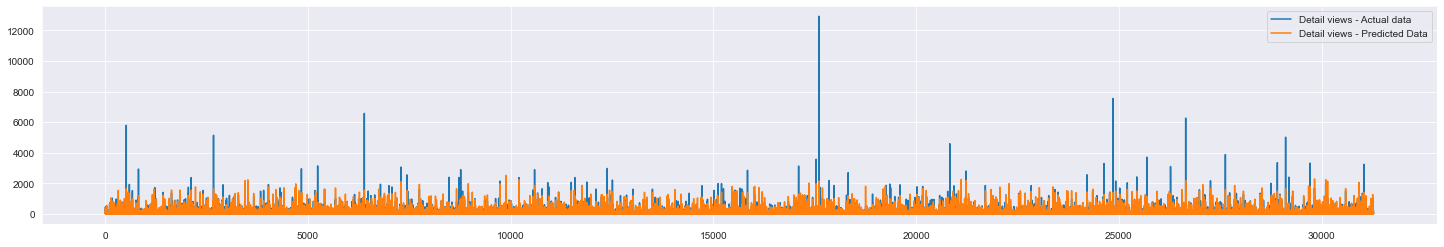

In [34]:
plt.rcParams["figure.figsize"] = (25,4)
sns.set_style("darkgrid")
plt.plot(y_test.detail_views.values)
plt.plot(y_predicted)
plt.legend(['Detail views - Actual data', 'Detail views - Predicted Data'],loc='upper right')
plt.show()

### What could be done
1. We can observe that the model performs appreciably better at detail_views less than 4000 but the errors increase for the anomalies where the detail_views are greater than 5000. 
2. Understandably the model has overfitted which is also due to less variance in provided data. This could be avoided by inducing artificial samples to model the anomalies.
4. Replace the anomalies with the average values over a fixed window size and over a group of articles.
3. Replace certain features that are correlated with other ones as mentioned in the data_exploration notebook.